# Colours project

In [34]:
from PIL import Image #Python Imaging Library

import sys

import os

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

In [35]:
def RGB_histogram(values, name):
    '''
    RGB Histogram
    
    - Description:
        Creates an histogram for the frequency of RGB contributions in the image.
    
    - Parameters:
        values: the pixels RGB data as a list of tuples of length 3 (R, G and B)
        name: the name of the output image
    '''
    
    if not os.path.isdir("histograms"):
        os.makedirs("histograms")
        
    f = plt.figure(figsize=(15,10))
    plt.grid()
    color = ('firebrick','mediumseagreen','royalblue')
    for i,col in enumerate(color):
        plt.hist(np.array(values)[:,i], color = col, histtype = 'stepfilled', 
                     bins = 256, alpha = 0.6)
    plt.xlim([0,256])
    plt.title("RGB contributions for "+ name)
    plt.ylabel("Frequency")
    plt.xlabel("Contribution to the pixels")
    
    plt.savefig("histograms/RGB_contribution_" + name + ".png")

In [36]:
def multiple_images(images, outputname):
    '''
    Multiple Images
    
    - Description:
        Combines several images side by side.
    
    - Paramaters:
        images: images data
        outputname: output file name
    '''
    
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    
    new_im = Image.new('RGB', (total_width, max_height))
    
    x_offset = 0
    
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
        new_im.save(outputname +'.jpg')

In [37]:
def RGB_image(values, outputname, img, size):
    '''
    RGB Image
    
    - Description:
        Creates a composite side by side of the image and its RGB contributions
        
    - Parameters:
        values: image RGB data as a list of tuples of length 3 (R, G, B)
        outputname: output file name
        img: image data
        size: image size (width and height)
    '''
    
    if not os.path.isdir("RGBcomposites"):
        os.makedirs("RGBcomposites")
        
    r = [(d[0], 0, 0) for d in values]
    g = [(0, d[1], 0) for d in values]
    b = [(0, 0, d[2]) for d in values]
    
    width, height = size
    
    new_im1 = Image.new('RGB', (width, height))
    new_im2 = Image.new('RGB', (width*3, height))
    x_offset = 0
    for j in [r, g, b]:
        new_im1.putdata(j)
        new_im2.paste(new_im1, (x_offset,0))
        x_offset = x_offset + width
        
    I = [img, new_im2]
    final = multiple_images(I, "RGBcomposites/" + outputname)
    return(final)

In [38]:
def colors_plot(colors, size, img, name):
    '''
    Palette plotter
    
    - Description: 
        Given certain RGB value or values, plots side by side an image and those RGB values
        
    - Parameters:
        colors: list of RGB values to plot
        size: image size (width and height)
        img: image data
        name: name of the image
    '''
    
    if not os.path.isdir("ColorPalette"):
        os.makedirs("ColorPalette")
    
    sample = []
    number = len(colors)
    
    width, height = size
    
    for c in colors:
        sample = sample + ([c] * (round(width*height/number)-1))
        
    new_img = Image.new('RGB', (width, height))
    new_img.putdata(sample)
    
    images = [img, new_img]
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    new_im = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
        new_im.save('ColorPalette/ColorPalette_' + name +'.jpg')

In [39]:
import binascii
import struct
import scipy
import scipy.misc
import scipy.cluster

def ColorClustering(num_cluster, image):
    '''
    Color Clustering
    
    - Description:
        Using K-means clustering extracts the principal color present in an image.
        This function uses double clustering, the first one extracts the num_cluster[0] principal
        colors from an image, then the second one clusters those colors in num_cluster[1] colors.
        
    -Parameters:
        num_cluster: list of clusters of length 2
        image: image data
    '''
    
    ar = np.asarray(image)
    shape = ar.shape
    ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)

    codes, dist = scipy.cluster.vq.kmeans(ar, num_cluster[0])
    codes = np.around(codes)
    codes = codes.astype(int)
    firstcluster= list(map(tuple, codes))
    
    secondcluster = np.asarray(firstcluster).astype(float)
    shape = secondcluster.shape
    codes, dist = scipy.cluster.vq.kmeans(secondcluster, num_cluster[1])
    codes = np.around(codes)
    codes = codes.astype(int)
    final = list(map(tuple, codes))
    
    return(final)

In [40]:
class ImageAnalizer(object):
    
    def __init__(self, path, num_clusters):
        self.path = path
        self.name = path.split('/')[1].split(".", 1)[0]
        self.img = Image.open(path)
        self.pix = self.img.load()
        self.size = self.img.size
        self.total_pixels = self.size[0]*self.size[1]
        self.pixel_values = list(self.img.getdata())
        self.colors = ColorClustering(num_clusters, self.img)
        
    def RGB_graph(self):
        return(RGB_histogram(self.pixel_values, self.name))
    
    def RGB_composite(self):
         return(RGB_image(self.pixel_values, 'RGB_composite_' + self.name, self.img, self.size))
        
    def Color_palette(self):
        return(colors_plot(self.colors, self.size, self.img, self.name))


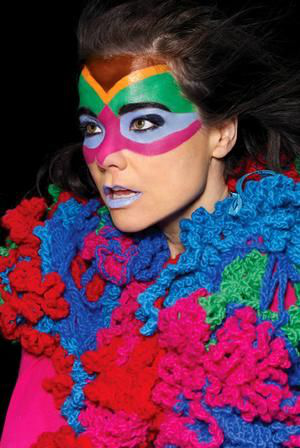

In [41]:
Imagen = ImageAnalizer("Imgs/bjork.jpg", [30,7])
Imagen.img

In [42]:
Imagen.RGB_composite()

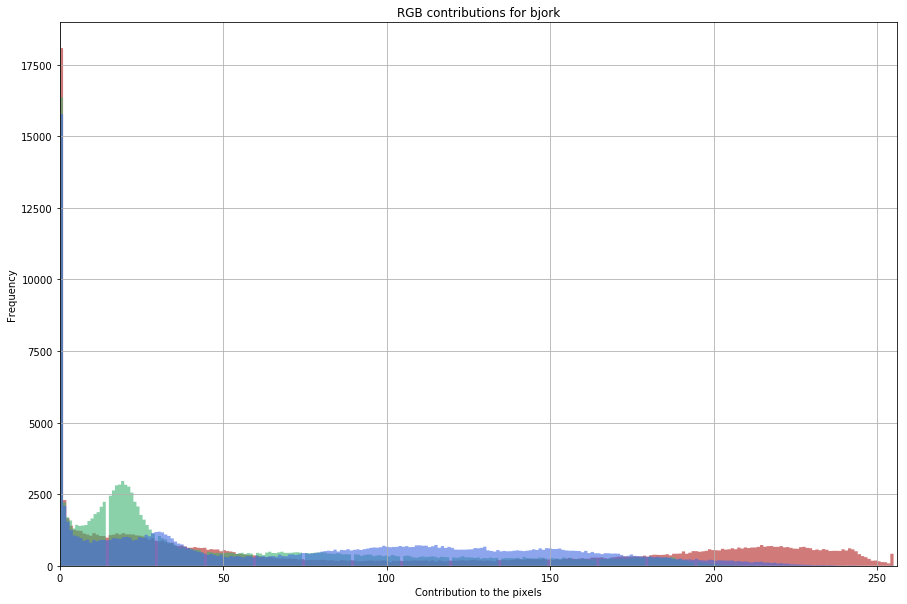

In [43]:
Imagen.RGB_graph()

In [44]:
Imagen.Color_palette()

In [45]:
Imagen.colors

[(38, 99, 171),
 (179, 20, 46),
 (16, 12, 13),
 (82, 41, 73),
 (186, 148, 132),
 (39, 154, 104),
 (216, 31, 116)]